In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.rcParams.update({'font.size': 14})
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=2)

## Distillation

In [2]:
def get_cifar10_transform(size, train=True):
    if train:
        transform = T.Compose([
            T.RandomCrop(size, padding=4),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

    else:
        transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

    return transform

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.grid()
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

def count_params(model):
    return sum(param.numel() for param in model.parameters())

In [3]:
train_set = CIFAR10('CIFAR10', train=True, download=True,
                    transform=get_cifar10_transform(32, train=True))
test_set = CIFAR10('CIFAR10', train=False, download=True,
                   transform=get_cifar10_transform(32, train=False))

train_loader = DataLoader(train_set, batch_size=256, pin_memory=True, num_workers=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, pin_memory=True, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
from torch import nn

class ConvNet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
        )
        self.head = nn.Linear(64, 10)
        
    def forward(self, images):
        features = self.features(images)
        features = features.mean(dim=(2, 3))
        logits = self.head(features)
        return logits

### Training from scratch

In [5]:
student = ConvNet().to(device)
optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)
ce_critetion = nn.CrossEntropyLoss()

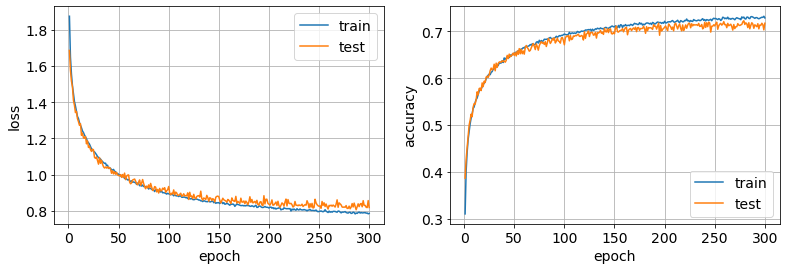

Best test accuracy: 0.7228


In [6]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 300

for epoch in range(1, num_epochs + 1):
    student.train()
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        logits = student(images)
        loss = ce_critetion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    train_losses += [running_loss / len(train_loader.dataset)]
    train_accuracies += [running_accuracy / len(train_loader.dataset)]
    
    student.eval()
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = student(images)
            loss = ce_critetion(logits, labels)
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    test_losses += [running_loss / len(test_loader.dataset)]
    test_accuracies += [running_accuracy / len(test_loader.dataset)]
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

print(f'Best test accuracy: {max(test_accuracies)}')

### Training with knowledge distillation

In [7]:
import torch.nn.functional as F

class DistillationLoss(nn.Module):
    def forward(self, student_logits, teacher_logits):
        student_log_probs = F.log_softmax(student_logits, dim=-1)
        with torch.no_grad():
            teacher_probs = F.softmax(teacher_logits, dim=-1)
        
        return -(teacher_probs * student_log_probs).sum(dim=-1).mean()

In [8]:
from torchvision.models import resnet18

teacher = resnet18(num_classes=10)
teacher.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2, bias=False)
teacher.maxpool = nn.Identity()

state = torch.load('resnet18-cifar10.pt')
teacher.load_state_dict(state)
teacher = teacher.eval().to(device)

In [9]:
student = ConvNet().to(device)
optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)
dist_criterion = DistillationLoss()
dist_lambda = 1
count_params(student), count_params(teacher)

(24234, 11173962)

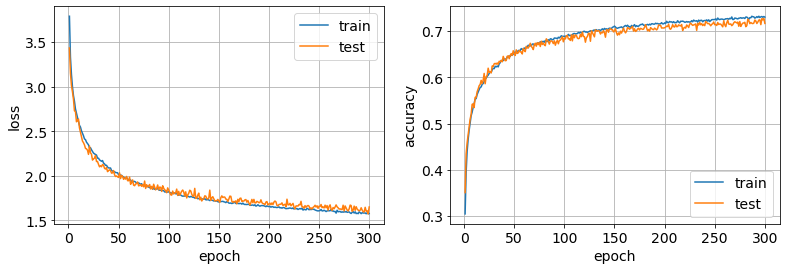

Best test accuracy: 0.7266


In [10]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 300

for epoch in range(1, num_epochs + 1):
    student.train()
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        student_logits = student(images)
        with torch.no_grad():
            teacher_logits = teacher(images)

        loss = ce_critetion(student_logits, labels) + \
               dist_lambda * dist_criterion(student_logits, teacher_logits)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (student_logits.argmax(dim=-1) == labels).sum().item()
        
    train_losses += [running_loss / len(train_loader.dataset)]
    train_accuracies += [running_accuracy / len(train_loader.dataset)]
    
    student.eval()
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            student_logits = student(images)
            teacher_logits = teacher(images)
            loss = ce_critetion(student_logits, labels) + \
                   dist_lambda * dist_criterion(student_logits, teacher_logits)
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (student_logits.argmax(dim=-1) == labels).sum().item()
        
    test_losses += [running_loss / len(test_loader.dataset)]
    test_accuracies += [running_accuracy / len(test_loader.dataset)]
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

print(f'Best test accuracy: {max(test_accuracies)}')

In [11]:
torch.save(student.state_dict(), 'student.pt')

## Pruning

In [12]:
def test(model):
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(images)
            loss = ce_critetion(logits, labels)
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
    
    running_loss /= len(test_loader.dataset)
    running_accuracy /= len(test_loader.dataset)
    return running_loss, running_accuracy

In [23]:
test(teacher)

(0.1793473183631897, 0.9526)

In [21]:
from torch.nn.utils import prune
import numpy as np
from copy import deepcopy

pruned_loss, pruned_acc = [], []
amounts = np.arange(0, 1.01, 0.01)
for amount in tqdm(amounts):
    pruned_student = deepcopy(student)
    params_to_prune = (
        (pruned_student.features[0], 'weight'),
        (pruned_student.features[2], 'weight'),
        (pruned_student.features[4], 'weight'),
    )

    prune.global_unstructured(
        params_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )
    
    loss, acc = test(pruned_student)
    pruned_loss += [loss]
    pruned_acc += [acc]

  0%|          | 0/101 [00:00<?, ?it/s]

In [27]:
teacher

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [28]:
pruned_loss, pruned_acc = [], []
amounts = np.arange(0, 1.01, 0.1)
for amount in tqdm(amounts):
    pruned_teacher = deepcopy(teacher)
    params_to_prune = (
        (pruned_teacher.layer1[0].conv1, 'weight'),
        (pruned_teacher.layer1[0].conv2, 'weight'),
        (pruned_teacher.layer1[1].conv1, 'weight'),
        (pruned_teacher.layer1[1].conv2, 'weight'),
        (pruned_teacher.layer2[0].conv1, 'weight'),
        (pruned_teacher.layer2[0].conv2, 'weight'),
        (pruned_teacher.layer2[1].conv1, 'weight'),
        (pruned_teacher.layer2[1].conv2, 'weight'),
        (pruned_teacher.layer3[0].conv1, 'weight'),
        (pruned_teacher.layer3[0].conv2, 'weight'),
        (pruned_teacher.layer3[1].conv1, 'weight'),
        (pruned_teacher.layer3[1].conv2, 'weight'),
        (pruned_teacher.layer4[0].conv1, 'weight'),
        (pruned_teacher.layer4[0].conv2, 'weight'),
        (pruned_teacher.layer4[1].conv1, 'weight'),
        (pruned_teacher.layer4[1].conv2, 'weight'),
        (pruned_teacher.fc, 'weight'),
    )

    prune.global_unstructured(
        params_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )
    
    loss, acc = test(pruned_teacher)
    pruned_loss += [loss]
    pruned_acc += [acc]

  0%|          | 0/11 [00:00<?, ?it/s]

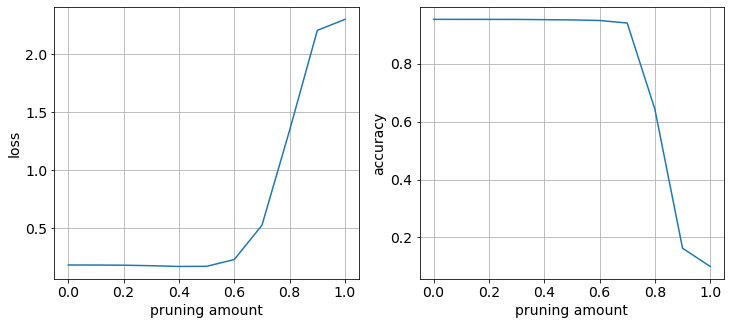

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(amounts, pruned_loss)
axs[1].plot(amounts, pruned_acc)

for ax in axs.flatten():
    ax.grid()
    ax.set_xlabel('pruning amount')

axs[0].set_ylabel('loss')
axs[1].set_ylabel('accuracy')
plt.show()